### Imports & declarations

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split

import keras
from keras.preprocessing.image import img_to_array, load_img, array_to_img, ImageDataGenerator
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf

LOCAL_PATH_MINI = '../data/raw/kaggle_mini_subsample'
LOCAL_PATH_TRAIN = '../data/raw/train'
COLAB_PATH_TRAIN = '/content/drive/MyDrive/Data Science/Colab Notebooks/Module 4 Project/data/raw/train'
COLAB_PATH_MINI = '/content/drive/MyDrive/Data Science/Colab Notebooks/Module 4 Project/data/raw/mini_subsample'

RANDOM_STATE = 2020

# Comment when running locally, uncomment for Google Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Define basic functions

In [5]:
def make_flat(x):
    s = x.shape
    dim_0 = s[0]
    dim_1 = s[1]*s[2]*s[3]
    x_flat = x.reshape(dim_0, dim_1)
    shape = (x_flat.shape[1],)
    return x_flat, shape

## Mini Dataset

#### Import & Clean

Found 186 images belonging to 2 classes.


'Example image:'

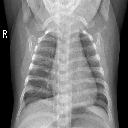

Indices: {'NORMAL': 0, 'PNEUMONIA': 1}
Dataset shape: (186, 128, 128, 3)


In [ ]:
BATCH_SIZE = 250
TARGET_SIZE = [128, 128]

path = COLAB_PATH_MINI
image_generator = ImageDataGenerator().flow_from_directory(path, batch_size=BATCH_SIZE, target_size=TARGET_SIZE);
images, labels = next(image_generator)
images_scaled = images / 255

display('Example image:', array_to_img(images[0]))
print('Indices:', image_generator.class_indices)
print('Dataset shape:', images_scaled.shape)

#### Mini Dataset Model

In [ ]:
x, shape = make_flat(images_scaled)

model = Sequential()
model.add(Dense(8, activation='relu', input_shape = shape))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x=x, y=labels, epochs=50)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                3145792   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 3,145,922
Trainable params: 3,145,922
Non-trainable params: 0
_________________________________________________________________


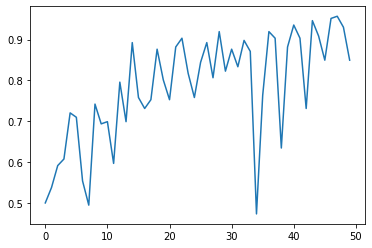

In [ ]:
acc = history.history['accuracy']
plt.plot(range(len(acc)), acc);
plt.title('Training accuracy for mini dataset')

## Full Dataset

### Import and clean

In [6]:
path = COLAB_PATH_TRAIN
BATCH_SIZE = 32
data_tf = tf.keras.preprocessing.image_dataset_from_directory(path, 
                                                image_size=(256, 256), # WORKS UP TO 256
                                                batch_size=BATCH_SIZE,
                                                seed=RANDOM_STATE)

for i, item in enumerate(data_tf.as_numpy_iterator()):
    if i == 0:
        images = np.array(item[0])
        labels = np.array(item[1])
    else:
        images = np.concatenate([images, item[0]], axis=0)
        labels = np.concatenate([labels, item[1]], axis=0)
        if i % 10 == 0:
            print(int(i/(5232/BATCH_SIZE)*100), '%')

images /= 256

labels_inverted = np.array([0 if i == 1 else 1 for i in labels])
labels = np.concatenate([labels_inverted.reshape(-1,1), labels.reshape(-1,1)], axis=1)

data_tf = None # clear RAM
print('Data shape:', images.shape)
print('Label shape:', labels.shape)

Found 5232 files belonging to 2 classes.
3 %
6 %
9 %
12 %
15 %
18 %
21 %
24 %
27 %
30 %
33 %
36 %
39 %
42 %
45 %
48 %
51 %
55 %
58 %
61 %
64 %
67 %
70 %
73 %
76 %
79 %
82 %
85 %
88 %
91 %
94 %
97 %
Data shape: (5232, 256, 256, 3)
Label shape: (5232, 2)


In [46]:
# BATCH_SIZE_TRAIN = 1341+3875
# TARGET_SIZE = [256, 256]

# path = COLAB_PATH_TRAIN

# t0 = time.time()
# generator = ImageDataGenerator().flow_from_directory(path,
#                                                      #batch_size=BATCH_SIZE_TRAIN,
#                                                      target_size=TARGET_SIZE)

# images, labels = next(generator)
# images = images / 256
# t1 = time.time()

# print('Runtime:', t1-t0)
# print(images.shape, labels.shape)

### Baseline Model

In [ ]:
x, shape = make_flat(images)

model = Sequential()
model.add(Dense(10, input_shape = shape))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='SGD', metrics=['accuracy', 'mse'], loss='categorical_crossentropy')


history = model.fit(x=x, y=labels, 
                    epochs=100, 
                    validation_split=0.25)

history.summary()
history['val_acc']

### Define Early Stopping

In [ ]:
early_stopping = [EarlyStopping(monitor='val_loss', patience=10),
                 ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)]

### Entire train dataset, validation split

##### Create and fit model

In [11]:
x, shape = make_flat(images)

model = Sequential()
model.add(Dense(32, activation='relu', input_shape = shape))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy', 'mse'])
model.summary()

history = model.fit(x=x, y=labels_train, 
                    callbacks = early_stopping,
                    epochs=50, 
                    validation_split=0.25, 
                    verbose=2)

best_model = keras.models.load_model('best_model.h5')
display(best_model.summary())

NameError: ignored

##### Plot results

In [ ]:
acc_train = history.history['accuracy']
acc_val = history.history['val_accuracy']
epoch_ct = range(len(acc_train))

plt.plot(epoch_ct, acc_train, label='Training')
plt.plot(epoch_ct, acc_val, label='Validation')
plt.title('Accuracy')
plt.legend();

In [ ]:
history.history.keys()

mse_train = history.history['mse']
mse_val = history.history['val_mse']
epoch_ct = range(len(mse_train))

plt.plot(epoch_ct, mse_train, label='Training')
plt.plot(epoch_ct, mse_val, label='Validation')
plt.title('Mean Squared Error')
plt.legend();

### Create balanced dataset

In [7]:
x_train, x_val, y_train, y_val = train_test_split(images, labels, 
                                                  random_state=RANDOM_STATE, 
                                                  test_size = 0.25)
images = None # clear memory

In [48]:
y_train.shape

(3924, 2)

In [8]:
# Oversample the minority class: 
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#oversample_the_minority_class
np.random.seed(RANDOM_STATE)


ind_neg = y_train[:, 0]==1
ind_pos = y_train[:, 0]==0

neg_ct = ind_neg.sum()
pos_ct = ind_pos.sum()
print('NORMAL count:', neg_ct, ', PNEUMONIA count:', pos_ct)

ids = np.arange(neg_ct)

# Select random entries from the list of inputs
ind_add_ons = np.random.choice(ids, size=pos_ct-neg_ct)
add_ons_x = x_train[ind_neg][ind_add_ons]
add_ons_y = y_train[ind_neg][ind_add_ons]

x_train_balanced = np.concatenate([x_train, add_ons_x], axis=0)
y_train_balanced = np.concatenate([y_train, add_ons_y], axis=0)
print('Training sizes after resampling:', x_train_balanced.shape, y_train_balanced.shape)
print('NORMAL count, PNEUMONIA count:', y_train_balanced.sum(axis=0))

# clear memory
x_train = None
y_train = None

NORMAL count: 1008 , PNEUMONIA count: 2916
Training sizes after resampling: (5832, 256, 256, 3) (5832, 2)
NORMAL count, PNEUMONIA count: [2916 2916]


### Create model with resampled dataset

In [ ]:
x_train_flat, shape = make_flat(x_train_balanced)
x_val_flat, _ = make_flat(x_val)

model = Sequential()
model.add(Dense(8, activation='relu', input_shape = shape))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy', 'mse'])

In [ ]:
history = model.fit(x=x_train_flat, y=y_train_balanced, epochs=50, validation_data=(x_val_flat, y_val))
model.summary()

### Add Regularization

In [ ]:
LAMBDA = 0.005

model = Sequential()
model.add(Dense(256, activation='relu', input_shape = shape, kernel_regularizer=regularizers.l2(LAMBDA)))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(LAMBDA)))
model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(LAMBDA)))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='SGD', metrics=['accuracy', 'mse'], loss='categorical_crossentropy')

history = model.fit(x=x_train_flat, y=y_train_balanced, 
                    callbacks=early_stopping, 
                    epochs=250, 
                    validation_data=(x_val_flat, y_val))

best_model = keras.models.load_model('best_model.h5')
best_model.summary()

### Add Dropout

In [9]:
x_train_flat, shape = make_flat(x_train_balanced)
x_val_flat, _ = make_flat(x_val)
early_stopping = [EarlyStopping(monitor='val_loss', patience=10),
                 ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)]

LAMBDA = 0.005
DROPOUT = 0.3

t0 = time.time()


model = Sequential()
model.add(Dense(256, activation='relu', input_shape = shape, kernel_regularizer=regularizers.l2(LAMBDA)))
model.add(Dropout(DROPOUT))

model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(LAMBDA)))
model.add(Dropout(DROPOUT))

model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(LAMBDA)))
model.add(Dropout(DROPOUT))

model.add(Dense(2, activation='softmax'))

model.compile(optimizer='SGD', metrics=['accuracy', 'mse'], loss='categorical_crossentropy')

model.fit(x=x_train_flat, y=y_train_balanced, 
          callbacks=early_stopping, 
          epochs=250, 
          validation_data=(x_val_flat, y_val), verbose=2)

best_model = keras.models.load_model('best_model.h5')
best_model.summary()

print('Full runtime:', time.time() - t0)

Epoch 1/250
183/183 - 20s - loss: 3.9018 - accuracy: 0.4942 - mse: 0.2639 - val_loss: 3.7290 - val_accuracy: 0.7393 - val_mse: 0.2300
Epoch 2/250
183/183 - 5s - loss: 3.7105 - accuracy: 0.5412 - mse: 0.2482 - val_loss: 3.6767 - val_accuracy: 0.2645 - val_mse: 0.2592
Epoch 3/250
183/183 - 5s - loss: 3.4765 - accuracy: 0.7112 - mse: 0.1913 - val_loss: 3.8376 - val_accuracy: 0.2798 - val_mse: 0.3778
Epoch 4/250
183/183 - 5s - loss: 3.3113 - accuracy: 0.7707 - mse: 0.1627 - val_loss: 3.0018 - val_accuracy: 0.8976 - val_mse: 0.0720
Epoch 5/250
183/183 - 5s - loss: 3.2014 - accuracy: 0.8085 - mse: 0.1577 - val_loss: 3.2616 - val_accuracy: 0.7179 - val_mse: 0.2084
Epoch 6/250
183/183 - 5s - loss: 3.0946 - accuracy: 0.7649 - mse: 0.1567 - val_loss: 3.6468 - val_accuracy: 0.5245 - val_mse: 0.3509
Epoch 7/250
183/183 - 5s - loss: 2.9100 - accuracy: 0.8397 - mse: 0.1205 - val_loss: 3.2566 - val_accuracy: 0.4518 - val_mse: 0.2874
Epoch 8/250
183/183 - 5s - loss: 2.8026 - accuracy: 0.8663 - mse: 0.

### Remove the layer of 256 notes from previous model

In [ ]:
x_train_flat, shape = make_flat(x_train_balanced)
x_val_flat, _ = make_flat(x_val)
early_stopping = [EarlyStopping(monitor='val_loss', patience=10),
                 ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)]

LAMBDA = 0.005
DROPOUT = 0.3

t0 = time.time()

model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(LAMBDA)))
model.add(Dropout(DROPOUT))

model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(LAMBDA)))
model.add(Dropout(DROPOUT))

model.add(Dense(2, activation='softmax'))

model.compile(optimizer='SGD', metrics=['accuracy', 'mse'], loss='categorical_crossentropy')

model.fit(x=x_train_flat, y=y_train_balanced, 
          callbacks=early_stopping, 
          epochs=250, 
          validation_data=(x_val_flat, y_val), verbose=2)

best_model = keras.models.load_model('best_model.h5')
best_model.summary()

print('Full runtime:', time.time() - t0)